## Setup

In [29]:
import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar
import os
import urllib.request as urlreq

import torch
import os
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from torchvision import datasets, transforms, models

## Loading Dataset

In [37]:

    train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      ])
    val_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      ])
    
    train_data = datasets.ImageFolder('images/train',       
                    transform=train_transforms)
    test_data = datasets.ImageFolder('images/test',
                    transform=test_transforms)
    val_data = datasets.ImageFolder('images/validation',
                    transform=val_transforms)

    trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True)
    valloader =  torch.utils.data.DataLoader(val_data,batch_size=4, shuffle=True)
    


In [38]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'


Using the CPU. Overall speed may be slowed down


In [39]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Defining layers
        self.convLayer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.Dropout(p=0.2),
            nn.ReLU()
        )
            
        self.convLayer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.Dropout(p=0.2),
            nn.ReLU()
        )
        
        self.fcLayer3 = nn.Linear(36864,7) 
        
  
    def forward(self, x):

        #My forward pass 
        x = x.to(device)
        
        #2 layers which do convolution, relu and dropout
        x = self.convLayer1(x)
        x = self.convLayer2(x)
        
        #linear layer so we have right amount of output classes
        x = x.view(x.shape[0],-1)
        x = self.fcLayer3(x)
        
        return x 

model = Network().to(device)
criterion = nn.CrossEntropyLoss() # Specify the loss layer
print('Your network:')
print(summary(model, (3,48,48), device=device)) # visualize your model


# Set up optimization hyperparameters
learning_rate = 1e-3
weight_decay = 1e-5
num_epoch = 4  # TODO: Choose an appropriate number of training epochs
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                       weight_decay=weight_decay) # Try different optimizers


Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
           Dropout-2           [-1, 16, 48, 48]               0
              ReLU-3           [-1, 16, 48, 48]               0
            Conv2d-4           [-1, 16, 48, 48]           2,320
           Dropout-5           [-1, 16, 48, 48]               0
              ReLU-6           [-1, 16, 48, 48]               0
            Linear-7                    [-1, 7]         258,055
Total params: 260,823
Trainable params: 260,823
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.69
Params size (MB): 0.99
Estimated Total Size (MB): 2.71
----------------------------------------------------------------
None


In [40]:
%%time
def train(model, trainloader, valloader, num_epoch=10):  # Train the model
    print("Start training...")
    trn_loss_hist = []
    trn_acc_hist = []
    val_acc_hist = []
    model.train()  # Set the model to training mode
    for i in range(num_epoch):
        running_loss = []
        print('-----------------Epoch = %d-----------------' % (i+1))
        for batch, label in tqdm(trainloader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad()  # Clear gradients from the previous iteration
            # This will call Network.forward() that you implement
            pred = model(batch)
            loss = criterion(pred, label)  # Calculate the loss
            running_loss.append(loss.item())
            loss.backward()  # Backprop gradients to all tensors in the network
            optimizer.step()  # Update trainable weights
        print("\n Epoch {} loss:{}".format(i+1, np.mean(running_loss)))

        # Keep track of training loss, accuracy, and validation loss
        trn_loss_hist.append(np.mean(running_loss))
        trn_acc_hist.append(evaluate(model, trainloader))
        print("\n Evaluate on validation set...")
        val_acc_hist.append(evaluate(model, valloader))
    print("Done!")
    return trn_loss_hist, trn_acc_hist, val_acc_hist


def evaluate(model, loader):  # Evaluate accuracy on validation / test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    with torch.no_grad():  # Do not calculate grident to speed up computation
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred, dim=1) == label).sum().item()
        acc = correct/len(loader.dataset)
        print("\n Evaluation accuracy: {}".format(acc))
        return acc


trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, trainloader,
                                                  valloader, num_epoch)

##############################################################################
# TODO: Note down the evaluation accuracy on test set                        #
##############################################################################
print("\n Evaluate on test set")
evaluate(model, testloader)

  0%|          | 10/3606 [00:00<01:05, 55.12it/s]

Start training...
-----------------Epoch = 1-----------------


  2%|▏         | 63/3606 [00:00<00:11, 317.30it/s]


 Epoch 1 loss:1.711131458646446


  2%|▏         | 30/1767 [00:00<00:05, 297.64it/s]


 Evaluation accuracy: 0.42368767769225435

 Evaluate on validation set...


  0%|          | 10/3606 [00:00<00:38, 93.53it/s]


 Evaluation accuracy: 0.37347863005943954
-----------------Epoch = 2-----------------


  2%|▏         | 72/3606 [00:00<00:09, 357.88it/s]


 Epoch 2 loss:1.4813045059484173


  2%|▏         | 29/1767 [00:00<00:06, 288.69it/s]


 Evaluation accuracy: 0.574648082657236

 Evaluate on validation set...


  0%|          | 9/3606 [00:00<00:41, 85.81it/s]


 Evaluation accuracy: 0.42739881120860457
-----------------Epoch = 3-----------------


  2%|▏         | 64/3606 [00:00<00:11, 320.02it/s]


 Epoch 3 loss:1.2329570453570606


  2%|▏         | 27/1767 [00:00<00:06, 264.61it/s]


 Evaluation accuracy: 0.6707579224741697

 Evaluate on validation set...


  0%|          | 10/3606 [00:00<00:38, 92.78it/s]


 Evaluation accuracy: 0.4310784036229833
-----------------Epoch = 4-----------------


  2%|▏         | 67/3606 [00:00<00:10, 332.81it/s]


 Epoch 4 loss:0.9857942969747471


  3%|▎         | 59/1767 [00:00<00:05, 297.01it/s]


 Evaluation accuracy: 0.7840649053463699

 Evaluate on validation set...


  2%|▏         | 61/3600 [00:00<00:11, 306.08it/s]


 Evaluation accuracy: 0.41268044155108974
Done!

 Evaluate on test set


100%|██████████| 3600/3600 [00:10<00:00, 338.82it/s]


 Evaluation accuracy: 0.41597222222222224
CPU times: user 3min 57s, sys: 9.58 s, total: 4min 7s
Wall time: 3min 47s


0.41597222222222224

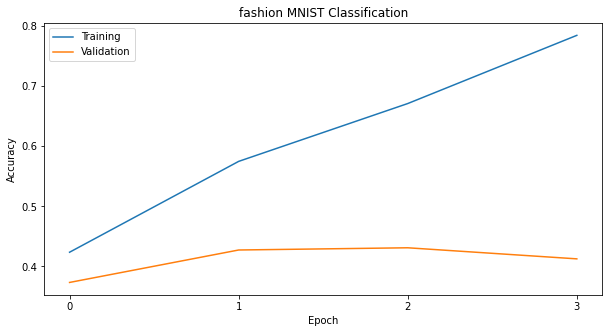

In [50]:
# visualize the training / validation accuracies
x = np.arange(num_epoch)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, trn_acc_hist)
plt.plot(x, val_acc_hist)
plt.legend(['Training', 'Validation'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Facial Recong Classification')
plt.gcf().set_size_inches(10, 5)
plt.savefig('part1.png', dpi=300)
plt.show()

In [42]:
def predict_image(image):
    test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      ])
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [43]:
def get_random_images(num):
    test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      ])
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

5
5
3
5
3


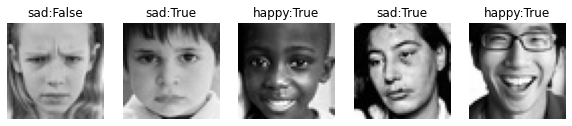

In [49]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
classes = trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    print(index)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [45]:
print(validationSet[0])
print(trainingSet.shape)
print(trainingSet[0])
print(cv2.imread("21.jpg").shape)

# LOADING THE TEST SET
testSet = Subset(trainingSet, range(7205))
trainloader = DataLoader(testSet, batch_size=1, shuffle=True)
valloader = DataLoader(testSet, batch_size=1, shuffle=True)
testloader = DataLoader(testSet, batch_size=1, shuffle=True)

plt.imshow(cv2.imread(validationSet[0]))

NameError: name 'validationSet' is not defined

## Facial Landmark Detector

In [ ]:
def get_landmarks(img_name):
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
    #img = cv2.imread(img_name)
    # save face detection algorithm's url in haarcascade_url variable
    haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml"

    # save face detection algorithm's name as haarcascade
    haarcascade = "haarcascade_frontalface_alt2.xml"

    # chech if file is in working directory
    if (haarcascade not in os.listdir(os.curdir)):
        # download file from url and save locally as haarcascade_frontalface_alt2.xml, < 1MB
        urlreq.urlretrieve(haarcascade_url, haarcascade)
        print("File downloaded")

    # create an instance of the Face Detection Cascade Classifier
    detector = cv2.CascadeClassifier(haarcascade)

    # Detect faces using the haarcascade classifier on the "grayscale image"
    faces = detector.detectMultiScale(img)

    if len(faces) == 0:
        faces = np.array([[0,0,48,48]])
        
    img = cv2.imread(img_name)
    LBFmodel_url = "https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml"

    # save facial landmark detection model's name as LBFmodel
    LBFmodel = "lbfmodel.yaml"

    # check if file is in working directory
    if (LBFmodel not in os.listdir(os.curdir)):
        # download picture from url and save locally as lbfmodel.yaml, < 54MB
        urlreq.urlretrieve(LBFmodel_url, LBFmodel)
        print("File downloaded")

    # create an instance of the Facial landmark Detector with the model
    landmark_detector  = cv2.face.createFacemarkLBF()
    landmark_detector.loadModel(LBFmodel)

    # Detect landmarks on "image_gray"
    _, landmarks = landmark_detector.fit(img, faces)

    for landmark in landmarks:
        for x,y in landmark[0]:
            # display landmarks on "image_cropped"
            # with white colour in BGR and thickness 1
            cv2.circle(img, (int(x), int(y)), 0, (255, 0, 0), 1)
    plt.axis("off")
    plt.imshow(img)
    
    return landmarks


In [ ]:
data = get_landmarks(validationSet[0])

## Model